In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

In [0]:
import os
os.chdir('drive/bertlab')

In [5]:
!ls

attention.py		    modeling_test.py
bert			    multilingual.md
bertbert.py		    optimization.py
bertcode		    optimization_test.py
berteval		    position.py
Bert-lab		    predicting_movie_reviews_with_bert_on_tf_hub.ipynb
BERTmodel		    __pycache__
CONTRIBUTING.md		    README.md
crazy.py		    requirements.txt
create_pretraining_data.py  run_classifier.py
download_glue_data.py	    run_classifier_with_tfhub.py
extract_features.py	    run_pretraining.py
feature			    run_squad.py
forbert			    sample_text.txt
__init__.py		    self_attention.py
labresult		    tokenization.py
LICENSE			    tokenization_test.py
modeling.py		    version2.ipynb


In [0]:
#loading self_attention module
import numpy as np
from keras import backend as K
from keras.engine import Layer
from keras.utils import get_custom_objects


class _BaseMultiHeadAttention(Layer):
  
    def __init__(self, num_heads: int, use_masking: bool,
                 dropout: float = 0.0,
                 compression_window_size: int = None,
                 **kwargs):
     

        self.num_heads = num_heads
        self.use_masking = use_masking
        self.dropout = dropout
        if (compression_window_size is not None
                and compression_window_size <= 0):
            assert ValueError(
                f"Too small compression window ({compression_window_size})")
        self.compression_window_size = compression_window_size
        super().__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config['num_heads'] = self.num_heads
        config['use_masking'] = self.use_masking
        config['dropout'] = self.dropout
        config['compression_window_size'] = self.compression_window_size
        return config

    def build_output_params(self, d_model):
        self.output_weights = self.add_weight(
            name='output_weights',
            shape=(d_model, d_model),
            initializer='glorot_uniform',
            trainable=True)
        if self.compression_window_size is not None:
            self.k_conv_kernel = self.add_weight(
                name='k_conv_kernel',
                shape=(self.compression_window_size,
                       d_model // self.num_heads,
                       d_model // self.num_heads),
                initializer='glorot_uniform',
                trainable=True)
            self.k_conv_bias = self.add_weight(
                name='k_conv_bias',
                shape=(d_model // self.num_heads,),
                initializer='zeros',
                trainable=True)
            self.v_conv_kernel = self.add_weight(
                name='v_conv_kernel',
                shape=(self.compression_window_size,
                       d_model // self.num_heads,
                       d_model // self.num_heads),
                initializer='glorot_uniform',
                trainable=True)
            self.v_conv_bias = self.add_weight(
                name='v_conv_bias',
                shape=(d_model // self.num_heads,),
                initializer='zeros',
                trainable=True)

    def validate_model_dimensionality(self, d_model: int):
        if d_model % self.num_heads != 0:
            raise ValueError(
                f'The size of the last dimension of the input '
                f'({d_model}) must be evenly divisible by the number'
                f'of the attention heads {self.num_heads}')

    def attention(self, pre_q, pre_v, pre_k, out_seq_len: int, d_model: int,
                  training=None):
  
        # shaping Q and V into (batch_size, num_heads, seq_len, d_model//heads)
        q = K.permute_dimensions(pre_q, [0, 2, 1, 3])
        v = K.permute_dimensions(pre_v, [0, 2, 1, 3])

        if self.compression_window_size is None:
            k_transposed = K.permute_dimensions(pre_k, [0, 2, 3, 1])
        else:
            if self.use_masking:
                raise NotImplementedError(
                    "Masked memory-compressed attention has not "
                    "been implemented yet")
            k = K.permute_dimensions(pre_k, [0, 2, 1, 3])
            k, v = [
                K.reshape(
                    # Step 3: Return the result to its original dimensions
                    # (batch_size, num_heads, seq_len, d_model//heads)
                    K.bias_add(
                        # Step 3: ... and add bias
                        K.conv1d(
                            # Step 2: we "compress" K and V using strided conv
                            K.reshape(
                                # Step 1: we reshape K and V to
                                # (batch + num_heads,  seq_len, d_model//heads)
                                item,
                                (-1,
                                 K.int_shape(item)[-2],
                                 d_model // self.num_heads)),
                            kernel,
                            strides=self.compression_window_size,
                            padding='valid', data_format='channels_last'),
                        bias,
                        data_format='channels_last'),
                    # new shape
                    K.concatenate([
                        K.shape(item)[:2],
                        [-1, d_model // self.num_heads]]))
                for item, kernel, bias in (
                    (k, self.k_conv_kernel, self.k_conv_bias),
                    (v, self.v_conv_kernel, self.v_conv_bias))]
            k_transposed = K.permute_dimensions(k, [0, 1, 3, 2])
        # shaping K into (batch_size, num_heads, d_model//heads, seq_len)
        # for further matrix multiplication
        sqrt_d = K.constant(np.sqrt(d_model // self.num_heads),
                            dtype=K.floatx())
        q_shape = K.int_shape(q)
        k_t_shape = K.int_shape(k_transposed)
        v_shape = K.int_shape(v)
        # before performing batch_dot all tensors are being converted to 3D
        # shape (batch_size * num_heads, rows, cols) to make sure batch_dot
        # performs identically on all backends
        attention_heads = K.reshape(
            K.batch_dot(
                self.apply_dropout_if_needed(
                    K.softmax(
                        self.mask_attention_if_needed(
                            K.batch_dot(
                                K.reshape(q, (-1,) + q_shape[-2:]),
                                K.reshape(k_transposed,
                                          (-1,) + k_t_shape[-2:]))
                            / sqrt_d)),
                    training=training),
                K.reshape(v, (-1,) + v_shape[-2:])),
            (-1, self.num_heads, q_shape[-2], v_shape[-1]))
        attention_heads_merged = K.reshape(
            K.permute_dimensions(attention_heads, [0, 2, 1, 3]),
            (-1, d_model))
        attention_out = K.reshape(
            K.dot(attention_heads_merged, self.output_weights),
            (-1, out_seq_len, d_model))
        return attention_out

    def apply_dropout_if_needed(self, attention_softmax, training=None):
        if 0.0 < self.dropout < 1.0:
            def dropped_softmax():
                return K.dropout(attention_softmax, self.dropout)

            return K.in_train_phase(dropped_softmax, attention_softmax,
                                    training=training)
        return attention_softmax

    def mask_attention_if_needed(self, dot_product):
        if not self.use_masking:
            return dot_product
        last_dims = K.int_shape(dot_product)[-2:]
        low_triangle_ones = (
            np.tril(np.ones(last_dims))
            # to ensure proper broadcasting
            .reshape((1,) + last_dims))
        inverse_low_triangle = 1 - low_triangle_ones
        close_to_negative_inf = -1e9
        result = (
            K.constant(low_triangle_ones, dtype=K.floatx()) * dot_product +
            K.constant(close_to_negative_inf * inverse_low_triangle))
        return result


class MultiHeadAttention(_BaseMultiHeadAttention):

    def build(self, input_shape):
        if not (isinstance(input_shape, list) and len(input_shape) == 2):
            raise ValueError(
                'You must call this layer passing a list of two tensors'
                '(for keys/values and queries)')
        values_dim, query_dim = input_shape[0][-1], input_shape[1][-1]
        if query_dim != values_dim:
            raise ValueError(
                f'Both keys/value and query inputs must be '
                f'of the same dimensionality, instead of '
                f'{values_dim} and {query_dim}.')
        d_model = query_dim
        self.validate_model_dimensionality(d_model)
      
        self.kv_weights = self.add_weight(
            name='kv_weights', shape=(d_model, d_model * 2),
            initializer='glorot_uniform', trainable=True)
        self.q_weights = self.add_weight(
            name='q_weights', shape=(d_model, d_model),
            initializer='glorot_uniform', trainable=True)
        self.build_output_params(d_model)
        return super().build(input_shape)

    def call(self, inputs, **kwargs):
        if not (isinstance(inputs, list) and len(inputs) == 2):
            raise ValueError(
                'You can call this layer only with a list of two tensors '
                '(for keys/values and queries)')
        key_values_input, query_input = inputs
        _, value_seq_len, d_model = K.int_shape(key_values_input)
        query_seq_len = K.int_shape(inputs[1])[-2]
        # The first thing we need to do is to perform affine transformations
        # of the inputs to get the Queries, the Keys and the Values.
        kv = K.dot(K.reshape(key_values_input, [-1, d_model]), self.kv_weights)
        # splitting the keys, the values and the queries before further
        # processing
        pre_k, pre_v = [
            K.reshape(
                # K.slice(kv, (0, i * d_model), (-1, d_model)),
                kv[:, i * d_model: (i + 1) * d_model],
                (-1, value_seq_len,
                 self.num_heads, d_model // self.num_heads))
            for i in range(2)]
        pre_q = K.reshape(
            K.dot(K.reshape(query_input, [-1, d_model]), self.q_weights),
            (-1, query_seq_len, self.num_heads, d_model // self.num_heads))
        return self.attention(pre_q, pre_v, pre_k, query_seq_len, d_model,
                              training=kwargs.get('training'))


class MultiHeadSelfAttention(_BaseMultiHeadAttention):

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError('Invalid input')
        d_model = input_shape[-1]
        self.validate_model_dimensionality(d_model)

        self.qkv_weights = self.add_weight(
            name='qkv_weights',
            shape=(d_model, d_model * 3),  # * 3 for q, k and v
            initializer='glorot_uniform',
            trainable=True)
        self.build_output_params(d_model)
        return super().build(input_shape)

    def call(self, inputs, **kwargs):
        if not K.is_tensor(inputs):
            raise ValueError(
                'The layer can be called only with one tensor as an argument')
        _, seq_len, d_model = K.int_shape(inputs)
        # The first thing we need to do is to perform affine transformations
        # of the inputs to get the Queries, the Keys and the Values.
        qkv = K.dot(K.reshape(inputs, [-1, d_model]), self.qkv_weights)
        # splitting the keys, the values and the queries before further
        # processing
        pre_q, pre_k, pre_v = [
            K.reshape(
                # K.slice(qkv, (0, i * d_model), (-1, d_model)),
                qkv[:, i * d_model:(i + 1) * d_model],
                (-1, seq_len, self.num_heads, d_model // self.num_heads))
            for i in range(3)]
        attention_out = self.attention(pre_q, pre_v, pre_k, seq_len, d_model,
                                       training=kwargs.get('training'))
        return attention_out

    def compute_output_shape(self, input_shape):
        return input_shape


get_custom_objects().update({
    'MultiHeadSelfAttention': MultiHeadSelfAttention,
    'MultiHeadAttention': MultiHeadAttention,
})


In [0]:
import numpy as np
from keras import backend as K
from keras.engine import Layer
from keras.utils import get_custom_objects


def positional_signal(hidden_size: int, length: int,
                      min_timescale: float = 1.0, max_timescale: float = 1e4):
    if hidden_size % 2 != 0:
        raise ValueError(
            f"The hidden dimension of the model must be divisible by 2."
            f"Currently it is {hidden_size}")
    position = K.arange(0, length, dtype=K.floatx())
    num_timescales = hidden_size // 2
    log_timescale_increment = K.constant(
        (np.log(float(max_timescale) / float(min_timescale)) /
         (num_timescales - 1)),
        dtype=K.floatx())
    inv_timescales = (
            min_timescale *
            K.exp(K.arange(num_timescales, dtype=K.floatx()) *
                  -log_timescale_increment))
    scaled_time = K.expand_dims(position, 1) * K.expand_dims(inv_timescales, 0)
    signal = K.concatenate([K.sin(scaled_time), K.cos(scaled_time)], axis=1)
    return K.expand_dims(signal, axis=0)


class AddPositionalEncoding(Layer):

    def __init__(self, min_timescale: float = 1.0,
                 max_timescale: float = 1.0e4, **kwargs):
        self.min_timescale = min_timescale
        self.max_timescale = max_timescale
        self.signal = None
        super().__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config['min_timescale'] = self.min_timescale
        config['max_timescale'] = self.max_timescale
        return config

    def build(self, input_shape):
        _, length, hidden_size = input_shape
        self.signal = positional_signal(
            hidden_size, length, self.min_timescale, self.max_timescale)
        return super().build(input_shape)

    def call(self, inputs, **kwargs):
        return inputs + self.signal


class AddCoordinateEncoding(AddPositionalEncoding):

    def build(self, input_shape):
        super().build(input_shape)
        _, length, hidden_size = input_shape

    def call(self, inputs, step=None, **kwargs):
        if step is None:
            raise ValueError("Please, provide current Transformer's step"
                             "using 'step' keyword argument.")
        pos_encoded_added = super().call(inputs, **kwargs)
        step_signal = K.expand_dims(self.signal[:, step, :], axis=1)
        return pos_encoded_added + step_signal


class TransformerCoordinateEmbedding(Layer):

    def __init__(self, max_transformer_depth: int, **kwargs):
        self.max_depth = max_transformer_depth
        super().__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config['max_transformer_depth'] = self.max_depth
        return config

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        sequence_length, d_model = input_shape[-2:]
        self.word_position_embeddings = self.add_weight(
            shape=(sequence_length, d_model),
            initializer='uniform',
            name='word_position_embeddings',
            trainable=True)
        self.depth_embeddings = self.add_weight(
            shape=(self.max_depth, d_model),
            initializer='uniform',
            name='depth_position_embeddings',
            trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        depth = kwargs.get('step')
        if depth is None:
            raise ValueError("Please, provide current Transformer's step"
                             "using 'step' keyword argument.")
        result = inputs + self.word_position_embeddings
        if depth is not None:
            result = result + self.depth_embeddings[depth]
        return result


get_custom_objects().update({
    'TransformerCoordinateEmbedding': TransformerCoordinateEmbedding,
    'AddCoordinateEncoding': AddCoordinateEncoding,
    'AddPositionalEncoding': AddCoordinateEncoding,
})

In [0]:
class LayerNormalization(Layer):

    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super().__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config['axis'] = self.axis
        return config

    def build(self, input_shape):
        dim = input_shape[-1]
        self.gain = self.add_weight(
            name='gain',
            shape=(dim,),
            initializer='ones',
            trainable=True)
        self.bias = self.add_weight(
            name='bias',
            shape=(dim,),
            initializer='zeros',
            trainable=True)
        return super().build(input_shape)

    def call(self, inputs, **kwargs):
        mean = K.mean(inputs, axis=self.axis, keepdims=True)
        variance = K.mean(
            K.square(inputs - mean), axis=self.axis, keepdims=True)
        epsilon = K.constant(1e-5, dtype=K.floatx())
        normalized_inputs = (inputs - mean) / K.sqrt(variance + epsilon)
        result = self.gain * normalized_inputs + self.bias
        return result

(1) loading ham_docs...
 train_docs finished! shape is:(1280, 40, 768)
(2) loading spam_docs...
 val_docs finished! shape is:(320, 40, 768)
(3) shuffling docs & labels...
(4) splitting data set...
1280
160
160
1280
160
160
(3) building downstream model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 40, 768)           0         
_________________________________________________________________
add_positional_encoding_8 (A (None, 40, 768)           0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 40, 768)           0         
_________________________________________________________________
multi_head_self_attention_8  (None, 40, 768)           2359296   
_________________________________________________________________
layer_normalization_15 (Laye (None, 40, 768)           1536      
__________________

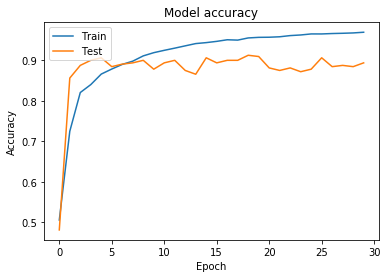

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.89      0.75      0.81        72
           1       0.82      0.92      0.87        88

   micro avg       0.84      0.84      0.84       160
   macro avg       0.85      0.84      0.84       160
weighted avg       0.85      0.84      0.84       160



In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as Backend
from scipy.special import softmax
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from self_attention import MultiHeadSelfAttention
from position import AddPositionalEncoding, TransformerCoordinateEmbedding


MAX_SENT_LENGTH = 240
MAX_SENTS = 40
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1

print('(1) loading ham_docs...')
ham_docs = np.load('forbert/ott/train_docs.npy')
print(' train_docs finished! shape is:'+str(np.shape(ham_docs)))

print('(2) loading spam_docs...')
spam_docs = np.load('forbert/ott/val_docs.npy')
print(' val_docs finished! shape is:'+str(np.shape(spam_docs)))

print('(3) shuffling docs & labels...')
ham_labels = open('forbert/ya.txt', encoding='utf-8').read().split('\n')
spam_labels = open('forbert/yb.txt', encoding='utf-8').read().split('\n')
all_labels = ham_labels + spam_labels

all_labels = to_categorical(np.asarray(all_labels))
all_docs = np.concatenate((ham_docs, spam_docs),axis=0)

idx = np.random.permutation(len(all_docs))
all_docs = all_docs[idx]
all_labels = all_labels[idx]

print('(4) splitting data set...')
p1 = int(len(all_docs)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(all_docs)*(1-TEST_SPLIT))
train_docs = all_docs[:p1]
val_docs = all_docs[p1:p2]
test_docs = all_docs[p2:]

train_labels = all_labels[:p1]
val_labels = all_labels[p1:p2]
test_labels = all_labels[p2:]

tf_train = tf.convert_to_tensor(train_docs, dtype=tf.float32)
tf_val = tf.convert_to_tensor(val_docs, dtype=tf.float32)
#tf_test = tf.convert_to_tensor(test_docs, dtype=tf.float32)

print(len(train_docs))
print(len(val_docs))
print(len(test_docs))
print(len(train_labels))
print(len(val_labels))
print(len(test_labels))

print('(3) building downstream model...')
doc_input = Input(shape=(MAX_SENTS, 768), dtype='float32')
pos = AddPositionalEncoding()(doc_input)
drop1 = Dropout(0.7)(pos)

doc_encoder = MultiHeadSelfAttention(num_heads=8, use_masking=False)(drop1)
ln1 = LayerNormalization()(doc_encoder)
drop2 = Dropout(0.7)(ln1)

flat = Flatten()(drop2)
dense = Dense(384, activation='relu')(flat)
ln2 = LayerNormalization()(dense)
drop3 = Dropout(0.7)(ln2)

pred = Dense(2, activation='sigmoid')(drop3)

model = Model(doc_input, pred)
model.summary()
#plot_model(model, to_file='D:/TBdata/result/model-so2bert.png',show_shapes=True)
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.9, epsilon=None, decay=0.0001, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print (model.metrics_names)
history = model.fit(tf_train, train_labels, validation_data=(tf_val, val_labels), epochs=30, steps_per_epoch=80, validation_steps=16)

print(model.evaluate(val_docs, val_labels))


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc, confusion_matrix, classification_report

y_score = model.predict(test_docs)
y_pred_labels = np.argmax(y_score, axis=1)
y_test_labels = np.argmax(test_labels, axis=1)


print("classification_report(left: labels):")
print(classification_report(y_test_labels, y_pred_labels))


(1) loading ham_docs...
 train_docs finished! shape is:(200, 24, 768)
(2) loading spam_docs...
 val_docs finished! shape is:(356, 24, 768)
(3) shuffling docs & labels...
(4) splitting data set...
444
56
56
444
56
56
(5) building downstream model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 24, 768)           0         
_________________________________________________________________
add_positional_encoding_5 (A (None, 24, 768)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 768)           0         
_________________________________________________________________
multi_head_self_attention_5  (None, 24, 768)           2359296   
_________________________________________________________________
layer_normalization_9 (Layer (None, 24, 768)           1536      
_________________________

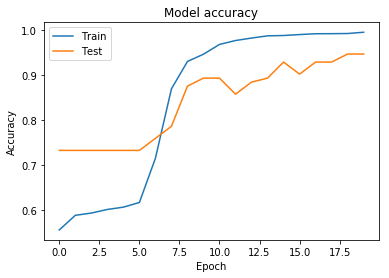

computing f1 score...
[[32  4]
 [ 3 17]]
False
False
[0.88888889 0.85      ]
[0.88888889 0.85      ]
[0.88888889 0.85      ]
classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        36
           1       0.81      0.85      0.83        20

   micro avg       0.88      0.88      0.88        56
   macro avg       0.86      0.87      0.87        56
weighted avg       0.88      0.88      0.88        56



In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as Backend
from scipy.special import softmax
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.utils import to_categorical


MAX_SENT_LENGTH = 210
MAX_SENTS = 24
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1

print('(1) loading ham_docs...')
ham_docs = np.load('forbert/ott/dr_ham.npy')
#tf_train=tf.convert_to_tensor(train_docs, dtype=tf.float32)
print(' train_docs finished! shape is:'+str(np.shape(ham_docs)))

print('(2) loading spam_docs...')
spam_docs = np.load('forbert/ott/dr_spam.npy')
#tf_val=tf.convert_to_tensor(val_docs, dtype=tf.float32)
print(' val_docs finished! shape is:'+str(np.shape(spam_docs)))

print('(3) shuffling docs & labels...')
ham_labels = open('forbert/ott/dr_ham.txt', encoding='utf-8').read().split('\n')
spam_labels = open('forbert/ott/dr_spam.txt', encoding='utf-8').read().split('\n')
all_labels = ham_labels + spam_labels

all_labels = to_categorical(np.asarray(all_labels))
all_docs = np.concatenate((ham_docs, spam_docs),axis=0)

idx = np.random.permutation(len(all_docs))
all_docs = all_docs[idx]
all_labels = all_labels[idx]

print('(4) splitting data set...')
p1 = int(len(all_docs)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(all_docs)*(1-TEST_SPLIT))
train_docs = all_docs[:p1]
val_docs = all_docs[p1:p2]
test_docs = all_docs[p2:]

train_labels = all_labels[:p1]
val_labels = all_labels[p1:p2]
test_labels = all_labels[p2:]

tf_train = tf.convert_to_tensor(train_docs, dtype=tf.float32)
tf_val = tf.convert_to_tensor(val_docs, dtype=tf.float32)
#tf_test = tf.convert_to_tensor(test_docs, dtype=tf.float32)

print(len(train_docs))
print(len(val_docs))
print(len(test_docs))
print(len(train_labels))
print(len(val_labels))
print(len(test_labels))

print('(5) building downstream model...')
doc_input = Input(shape=(MAX_SENTS, 768), dtype='float32')
pos = AddPositionalEncoding()(doc_input)
drop1 = Dropout(0.3)(pos)

doc_encoder = MultiHeadSelfAttention(num_heads=8, use_masking=False)(drop1)
ln1 = LayerNormalization()(doc_encoder)
drop2 = Dropout(0.3)(ln1)

flat = Flatten()(drop2)
dense = Dense(384, activation='relu')(flat)
ln2 = LayerNormalization()(dense)
drop3 = Dropout(0.3)(ln2)

pred = Dense(2, activation='sigmoid')(drop3)

model = Model(doc_input, pred)
model.summary()
#plot_model(model, to_file='D:/TBdata/result/model-so2bert.png',show_shapes=True)
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.9, epsilon=None, decay=0.0001, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print (model.metrics_names)
history = model.fit(tf_train, train_labels, validation_data=(tf_val, val_labels), epochs=20, steps_per_epoch=28, validation_steps=4)

print(model.evaluate(val_docs, val_labels))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc, confusion_matrix, classification_report

y_score = model.predict(test_docs)
y_pred_labels = np.argmax(y_score, axis=1)
y_test_labels = np.argmax(test_labels, axis=1)


print("classification_report(left: labels):")
print(classification_report(y_test_labels, y_pred_labels))

(1) loading ham_docs...
 train_docs finished! shape is:(200, 24, 768)
(2) loading spam_docs...
 val_docs finished! shape is:(200, 24, 768)
(3) shuffling docs & labels...
(4) splitting data set...
320
40
320
40
(5) building downstream model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 24, 768)           0         
_________________________________________________________________
add_positional_encoding_50 ( (None, 24, 768)           0         
_________________________________________________________________
dropout_148 (Dropout)        (None, 24, 768)           0         
_________________________________________________________________
multi_head_self_attention_50 (None, 24, 768)           2359296   
_________________________________________________________________
layer_normalization_99 (Laye (None, 24, 768)           1536      
_______________________________

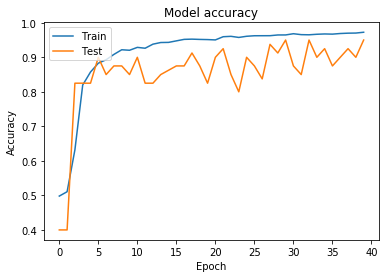

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       1.00      0.87      0.93        23

   micro avg       0.93      0.93      0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.94      0.93      0.93        40



In [0]:
MAX_SENT_LENGTH = 210
MAX_SENTS = 24
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1

print('(1) loading ham_docs...')
ham_docs = np.load('forbert/ott/res_ham.npy')
#tf_train=tf.convert_to_tensor(train_docs, dtype=tf.float32)
print(' train_docs finished! shape is:'+str(np.shape(ham_docs)))

print('(2) loading spam_docs...')
spam_docs = np.load('forbert/ott/res_spam.npy')
#tf_val=tf.convert_to_tensor(val_docs, dtype=tf.float32)
print(' val_docs finished! shape is:'+str(np.shape(spam_docs)))

print('(3) shuffling docs & labels...')
ham_labels = open('forbert/ott/res_ham.txt', encoding='utf-8').read().split('\n')
spam_labels = open('forbert/ott/res_spam.txt', encoding='utf-8').read().split('\n')
all_labels = ham_labels + spam_labels

all_labels = to_categorical(np.asarray(all_labels))
all_docs = np.concatenate((ham_docs, spam_docs),axis=0)

idx = np.random.permutation(len(all_docs))
all_docs = all_docs[idx]
all_labels = all_labels[idx]

print('(4) splitting data set...')
p1 = int(len(all_docs)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(all_docs)*(1-TEST_SPLIT))
train_docs = all_docs[:p1]
val_docs = all_docs[p1:p2]
test_docs = all_docs[p2:]

train_labels = all_labels[:p1]
val_labels = all_labels[p1:p2]
test_labels = all_labels[p2:]

tf_train = tf.convert_to_tensor(train_docs, dtype=tf.float32)
tf_val = tf.convert_to_tensor(val_docs, dtype=tf.float32)
#tf_test = tf.convert_to_tensor(test_docs, dtype=tf.float32)

print(len(train_docs))
print(len(val_docs))
#print(len(test_docs))
print(len(train_labels))
print(len(val_labels))
#print(len(test_labels))

print('(5) building downstream model...')
doc_input = Input(shape=(MAX_SENTS, 768), dtype='float32')
pos = AddPositionalEncoding()(doc_input)
drop1 = Dropout(0.7)(pos)

doc_encoder = MultiHeadSelfAttention(num_heads=8, use_masking=False)(drop1)
ln1 = LayerNormalization()(doc_encoder)
drop2 = Dropout(0.7)(ln1)

flat = Flatten()(drop2)
dense = Dense(384, activation='relu')(flat)
ln2 = LayerNormalization()(dense)
drop3 = Dropout(0.7)(ln2)

pred = Dense(2, activation='sigmoid')(drop3)

model = Model(doc_input, pred)
model.summary()
#plot_model(model, to_file='D:/TBdata/result/model-so2bert.png',show_shapes=True)
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.9, epsilon=None, decay=0.0001, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print (model.metrics_names)
history = model.fit(tf_train, train_labels, validation_data=(tf_val, val_labels), epochs=40, steps_per_epoch=40, validation_steps=8)

print(model.evaluate(val_docs, val_labels))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

from sklearn.metrics import roc_curve,auc, confusion_matrix, classification_report

y_score = model.predict(test_docs)
y_pred_labels = np.argmax(y_score, axis=1)
y_test_labels = np.argmax(test_labels, axis=1)

print("classification_report(left: labels):")
print(classification_report(y_test_labels, y_pred_labels))

(1) loading all docs...
 res_ham finished! shape is:(200, 24, 768)
 res_spam finished! shape is:(200, 24, 768)
 dr_ham finished! shape is:(200, 24, 768)
 dr_spam finished! shape is:(356, 24, 768)
 hot_ham finished! shape is:(1280, 40, 768)
 hot_spam finished! shape is:(320, 40, 768)
 all_docs shape is:(956, 24, 768)
 pad shape is:(956, 40, 768)
(2) shuffling docs & labels...
 all_labels shape is:(2556, 2)
(4) splitting data set...
2044
256
256
2044
256
256
(5) building downstream model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 40, 768)           0         
_________________________________________________________________
add_positional_encoding_7 (A (None, 40, 768)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 40, 768)           0         
____________________________________________

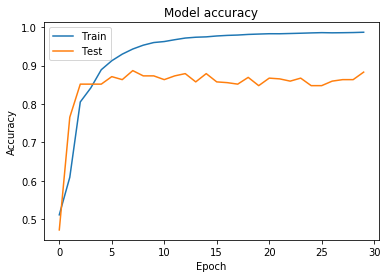

classification_report(left: labels):
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       119
           1       0.89      0.84      0.86       137

   micro avg       0.86      0.86      0.86       256
   macro avg       0.86      0.86      0.86       256
weighted avg       0.86      0.86      0.86       256



In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as Backend
from scipy.special import softmax
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.utils import to_categorical

MAX_SENT_LENGTH = 210
MAX_SENTS = 40
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1

print('(1) loading all docs...')
res_ham = np.load('forbert/ott/res_ham.npy')
print(' res_ham finished! shape is:'+str(np.shape(res_ham)))
res_spam = np.load('forbert/ott/res_spam.npy')
print(' res_spam finished! shape is:'+str(np.shape(res_spam)))
dr_ham = np.load('forbert/ott/dr_ham.npy')
print(' dr_ham finished! shape is:'+str(np.shape(dr_ham)))
dr_spam = np.load('forbert/ott/dr_spam.npy')
print(' dr_spam finished! shape is:'+str(np.shape(dr_spam)))
hot_ham = np.load('forbert/ott/train_docs.npy')
print(' hot_ham finished! shape is:'+str(np.shape(hot_ham)))
hot_spam = np.load('forbert/ott/val_docs.npy')
print(' hot_spam finished! shape is:'+str(np.shape(hot_spam)))

all_docs = np.concatenate((res_ham, res_spam, dr_ham, dr_spam),axis=0)
print(' all_docs shape is:'+str(np.shape(all_docs)))

pad = np.zeros((956, MAX_SENTS, 768))
pad[:all_docs.shape[0], :all_docs.shape[1], :all_docs.shape[2]] = all_docs
print(' pad shape is:'+str(np.shape(pad)))
all_docs = np.concatenate((pad, hot_ham, hot_spam),axis=0)


print('(2) shuffling docs & labels...')
res_ham_labels = open('forbert/ott/res_ham.txt', encoding='utf-8').read().split('\n')
res_spam_labels = open('forbert/ott/res_spam.txt', encoding='utf-8').read().split('\n')
dr_ham_labels = open('forbert/ott/dr_ham.txt', encoding='utf-8').read().split('\n')
dr_spam_labels = open('forbert/ott/dr_spam.txt', encoding='utf-8').read().split('\n')
hot_ham_labels = open('forbert/ya.txt', encoding='utf-8').read().split('\n')
hot_spam_labels = open('forbert/yb.txt', encoding='utf-8').read().split('\n')

all_labels = res_ham_labels+res_spam_labels+dr_ham_labels+dr_spam_labels+hot_ham_labels+hot_spam_labels
all_labels = to_categorical(np.asarray(all_labels))
print(' all_labels shape is:'+str(np.shape(all_labels)))

idx = np.random.permutation(len(all_docs))
all_docs = all_docs[idx]
all_labels = all_labels[idx]

print('(4) splitting data set...')
p1 = int(len(all_docs)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(all_docs)*(1-TEST_SPLIT))
train_docs = all_docs[:p1]
val_docs = all_docs[p1:p2]
test_docs = all_docs[p2:]

train_labels = all_labels[:p1]
val_labels = all_labels[p1:p2]
test_labels = all_labels[p2:]

tf_train = tf.convert_to_tensor(train_docs, dtype=tf.float32)
tf_val = tf.convert_to_tensor(val_docs, dtype=tf.float32)
#tf_test = tf.convert_to_tensor(test_docs, dtype=tf.float32)

print(len(train_docs))
print(len(val_docs))
print(len(test_docs))
print(len(train_labels))
print(len(val_labels))
print(len(test_labels))

print('(5) building downstream model...')
doc_input = Input(shape=(MAX_SENTS, 768), dtype='float32')
pos = AddPositionalEncoding()(doc_input)
drop1 = Dropout(0.6)(pos)

doc_encoder = MultiHeadSelfAttention(num_heads=8, use_masking=False)(drop1)
ln1 = LayerNormalization()(doc_encoder)
drop2 = Dropout(0.6)(ln1)

flat = Flatten()(drop2)
dense = Dense(384, activation='relu')(flat)
ln2 = LayerNormalization()(dense)
drop3 = Dropout(0.6)(ln2)

pred = Dense(2, activation='sigmoid')(drop3)

model = Model(doc_input, pred)
model.summary()
#plot_model(model, to_file='D:/TBdata/result/model-so2bert.png',show_shapes=True)
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.9, epsilon=None, decay=0.0001, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print (model.metrics_names)
history = model.fit(tf_train, train_labels, validation_data=(tf_val, val_labels), epochs=30, steps_per_epoch=128, validation_steps=16)

print(model.evaluate(val_docs, val_labels))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

from sklearn.metrics import roc_curve,auc, confusion_matrix, classification_report

y_score = model.predict(test_docs)
y_pred_labels = np.argmax(y_score, axis=1)
y_test_labels = np.argmax(test_labels, axis=1)

print("classification_report(left: labels):")
print(classification_report(y_test_labels, y_pred_labels))